In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [2]:
#Limiting data to that of the last 6 months.
from datetime import datetime
from dateutil.relativedelta import relativedelta
import calendar

now = datetime.today()
six_months = datetime.today() + relativedelta(months=-6, days = -3)

def convert(date):
    return str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

def convert_2(date):
    return datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')

def convert_3(date):
    return datetime.utcfromtimestamp(date).strftime('%Y-%m-%d')

def get_month(date):
    return datetime.strptime(date, '%Y-%m-%d').strftime('%B')

In [3]:
#Defining functions.
import requests
import io
import json

def coinmetrics(csv_name, start = six_months, end = now):
    
    time = (end - start).days

    url = 'https://coinmetrics.io/data/' + csv_name + '.csv'
    request = requests.get(url)
    
    coin = pd.read_csv(io.StringIO(request.text))[-time:]
    coin = coin[['date', 'txCount', 'marketcap(USD)', 'price(USD)', 'exchangeVolume(USD)']]
    coin.columns = ['Date', 'Transactions', 'Market Cap', 'Price', 'Exchange Volume']
    coin['Price Change'] = coin['Price'].pct_change()*100
    coin.reset_index(inplace = True, drop = True)
    
    return coin

def coinmarketcap(coin_name, start = six_months, end = now):
    
    start, end = convert(start), convert(end)
    
    coin = pd.read_html('https://coinmarketcap.com/currencies/' + coin_name + '/historical-data/?start=' + start
                        + '&end=' + end)[0]
    coin['Date'] = coin['Date'].apply(convert_2)
    coin = coin[['Date', 'Open*', 'Volume', 'Market Cap']]
    coin.columns = ['Date', 'Price', 'Exchange Volume', 'Market Cap']
    
    coin['Price'] = pd.to_numeric(coin['Price'], errors = 'coerce')
    coin['Exchange Volume'] = pd.to_numeric(coin['Exchange Volume'], errors = 'coerce')
    coin['Market Cap'] = pd.to_numeric(coin['Market Cap'], errors = 'coerce')

    coin = coin.iloc[::-1]
    coin['Price Change'] = coin['Price'].pct_change()*100
    
    return coin

def subreddit(subreddit_name, start = six_months, end = now):
    
    time = (end - start).days
    time_str = str(time + 1)
    
    sub = requests.get('https://api.pushshift.io/reddit/submission/search/?after=' + time_str +
                           'd&subreddit=' + subreddit_name + '&aggs=created_utc&frequency=d&size=0')
    sub_json = sub.json()
    submissions = pd.DataFrame(sub_json['aggs']['created_utc'])
    submissions.columns = ['Submissions', 'UTC']

    com = requests.get('https://api.pushshift.io/reddit/comment/search/?after=' + time_str +
                           'd&subreddit=' + subreddit_name + '&aggs=created_utc&frequency=d&size=0')
    com_json = com.json()
    comments = pd.DataFrame(com_json['aggs']['created_utc'])
    comments.columns = ['Comments', 'UTC']

    subreddit = submissions.merge(comments, on = 'UTC')
    subreddit['Date'] = subreddit['UTC'].apply(convert_3)

    return subreddit

def merged_coin(site_sub, subreddit_name, site_name = 'coinmetrics', start = six_months, end = now):

    if site_name == 'coinmetrics':
        coin = coinmetrics(site_sub, start, end)
    elif site_name == 'coinmarketcap':
        coin = coinmarketcap(site_sub, start, end)
        
    sub = subreddit(subreddit_name, start, end)
    coin = coin.merge(sub, on = 'Date')
    
    coin.drop('UTC', axis = 1, inplace = True)
    coin.dropna(inplace = True)
    coin.reset_index(inplace = True, drop = True)
    
    return coin

def correlation(site_sub, subreddit_name, site_name = 'coinmetrics', start = six_months, end = now,
                corr_type = 'pearson'):
    
    coin = merged_coin(site_sub, subreddit_name, site_name, start, end)
    coin['Month'] = coin['Date'].apply(get_month)
    
    sns.pairplot(coin, hue = 'Month', palette = 'viridis', diag_kind = 'hist')
    plt.show()
        
    return coin.corr(method = corr_type) #Change type of correlation here.

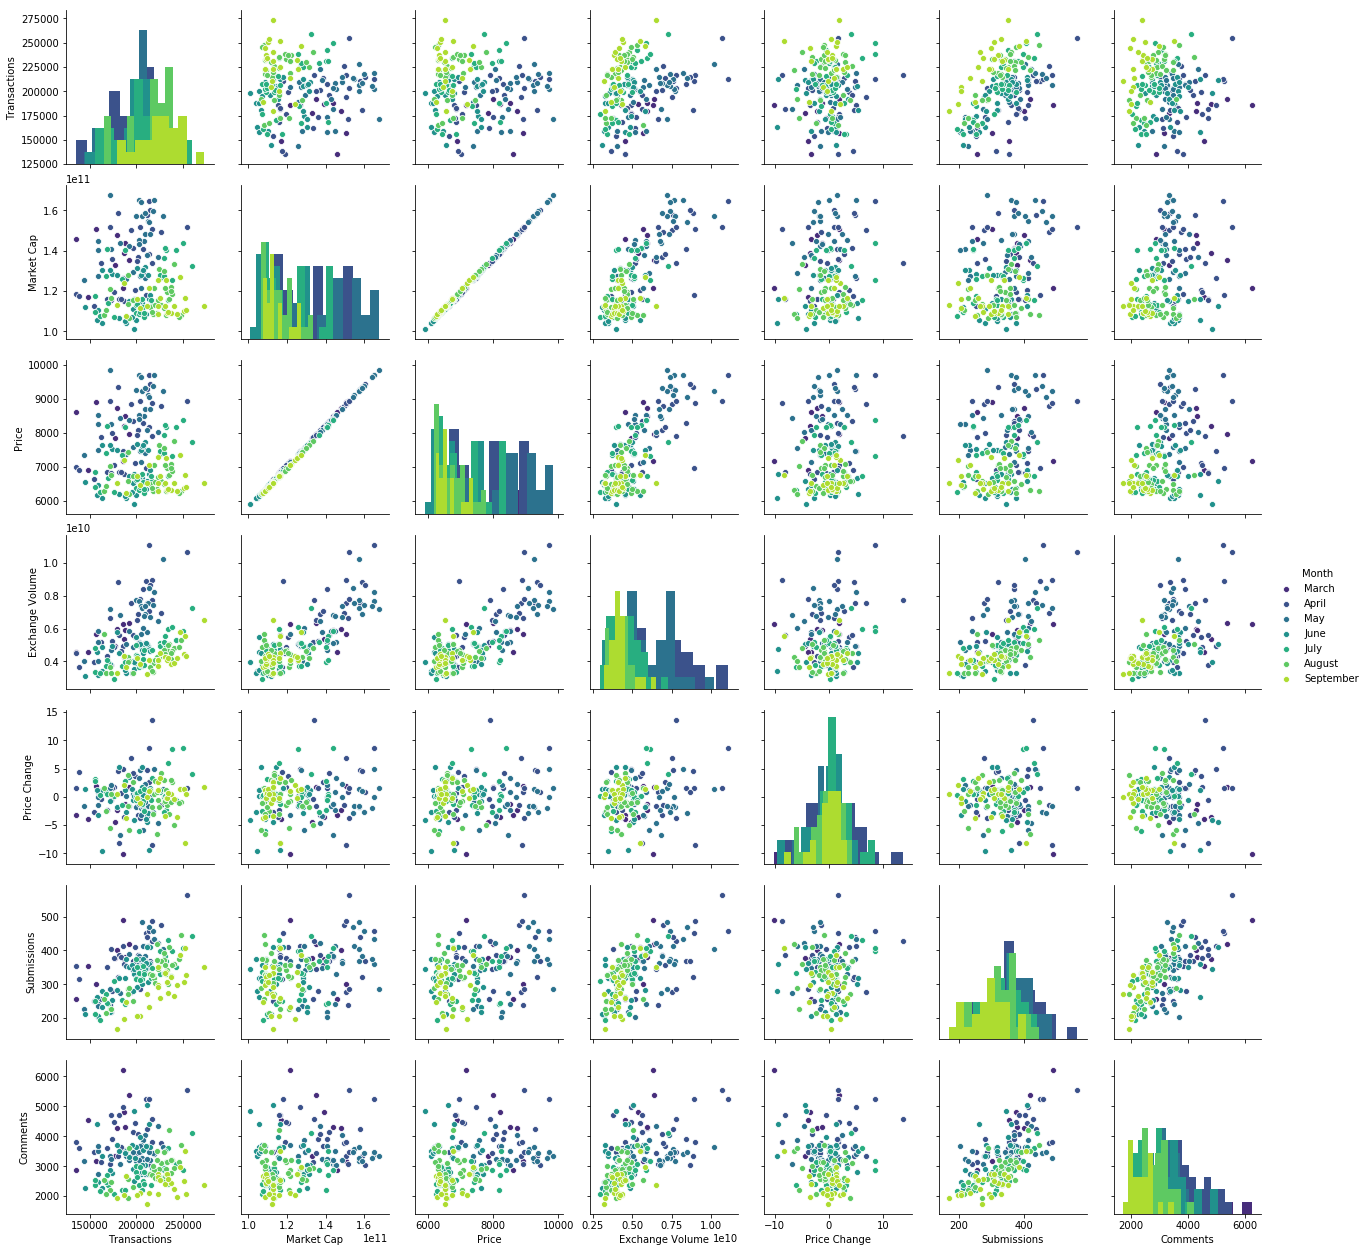

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,-0.013297,-0.033811,0.222150,0.079493,0.498954,-0.048978
Market Cap,-0.013297,1.000000,0.999357,0.761269,0.115632,0.306523,0.270942
Price,-0.033811,0.999357,1.000000,0.765798,0.111588,0.313528,0.292330
Exchange Volume,0.222150,0.761269,0.765798,1.000000,0.135331,0.575026,0.522818
Price Change,0.079493,0.115632,0.111588,0.135331,1.000000,-0.027853,-0.066325
Submissions,0.498954,0.306523,0.313528,0.575026,-0.027853,1.000000,0.645609
Comments,-0.048978,0.270942,0.292330,0.522818,-0.066325,0.645609,1.000000


In [4]:
#Bitcoin
correlation('btc', 'bitcoin')

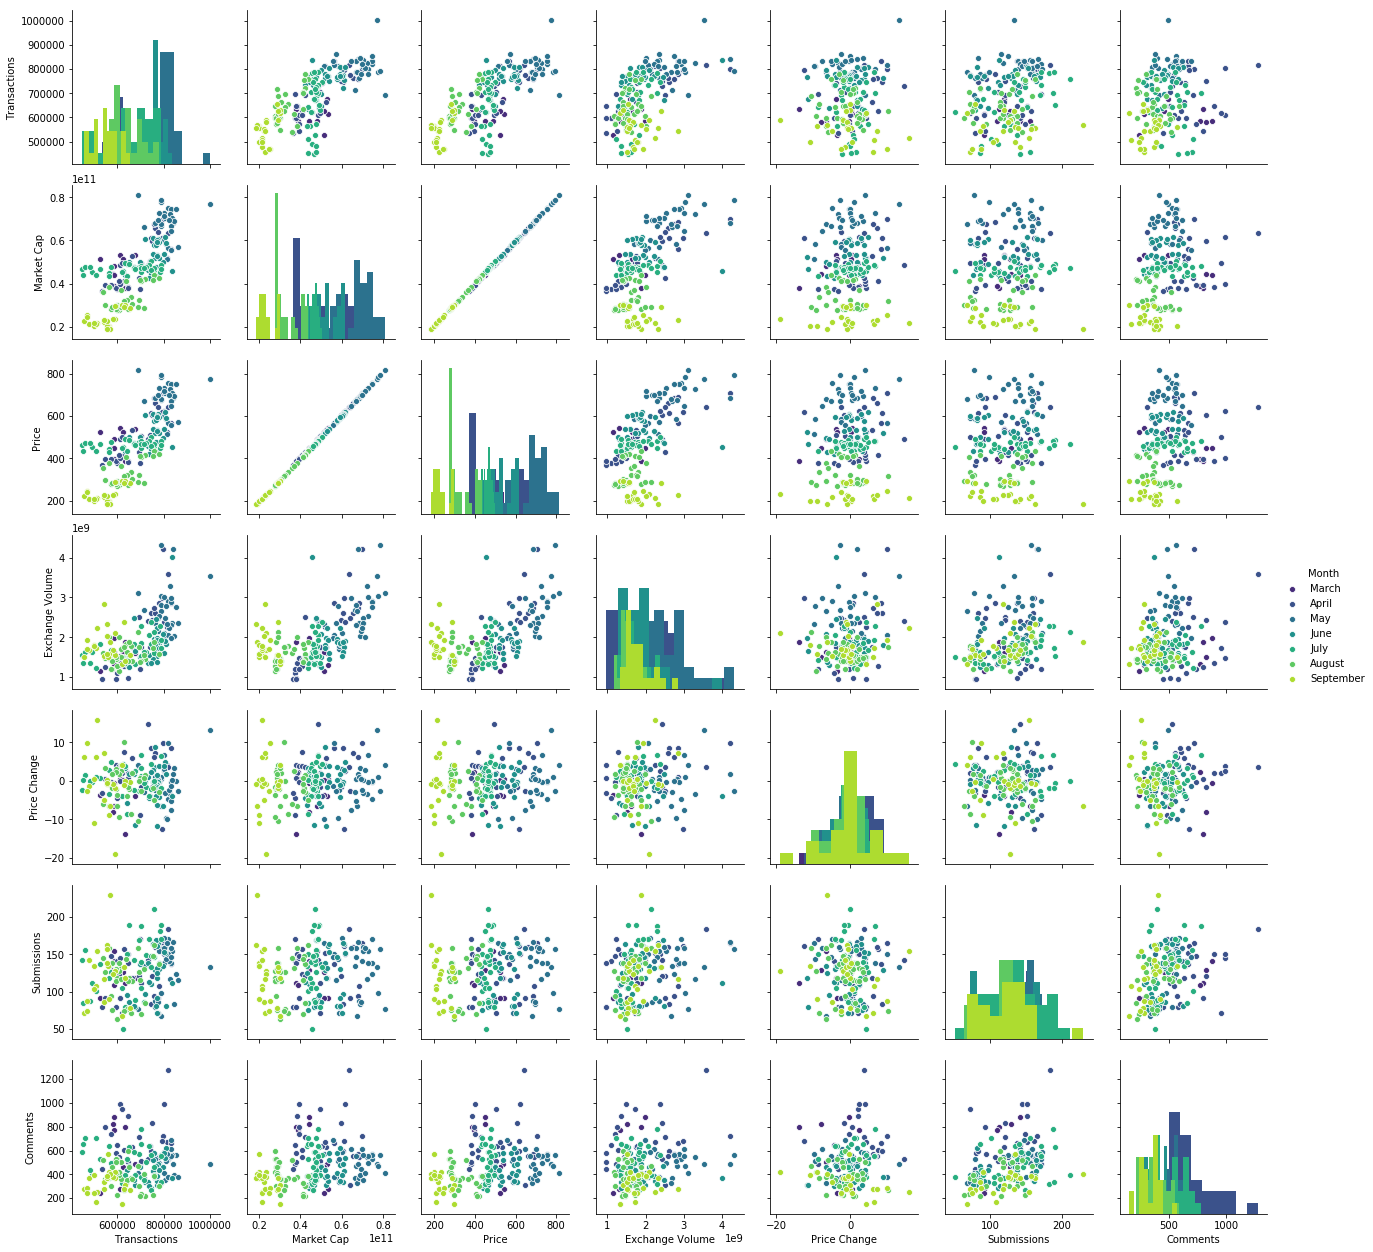

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.747914,0.744771,0.573293,0.045742,0.254496,0.126548
Market Cap,0.747914,1.000000,0.999770,0.580473,0.121305,0.106188,0.276351
Price,0.744771,0.999770,1.000000,0.580265,0.121447,0.105363,0.285551
Exchange Volume,0.573293,0.580473,0.580265,1.000000,0.107640,0.275482,0.189227
Price Change,0.045742,0.121305,0.121447,0.107640,1.000000,-0.053371,0.052778
Submissions,0.254496,0.106188,0.105363,0.275482,-0.053371,1.000000,0.323735
Comments,0.126548,0.276351,0.285551,0.189227,0.052778,0.323735,1.000000


In [5]:
#Ethereum
correlation('eth', 'ethereum')

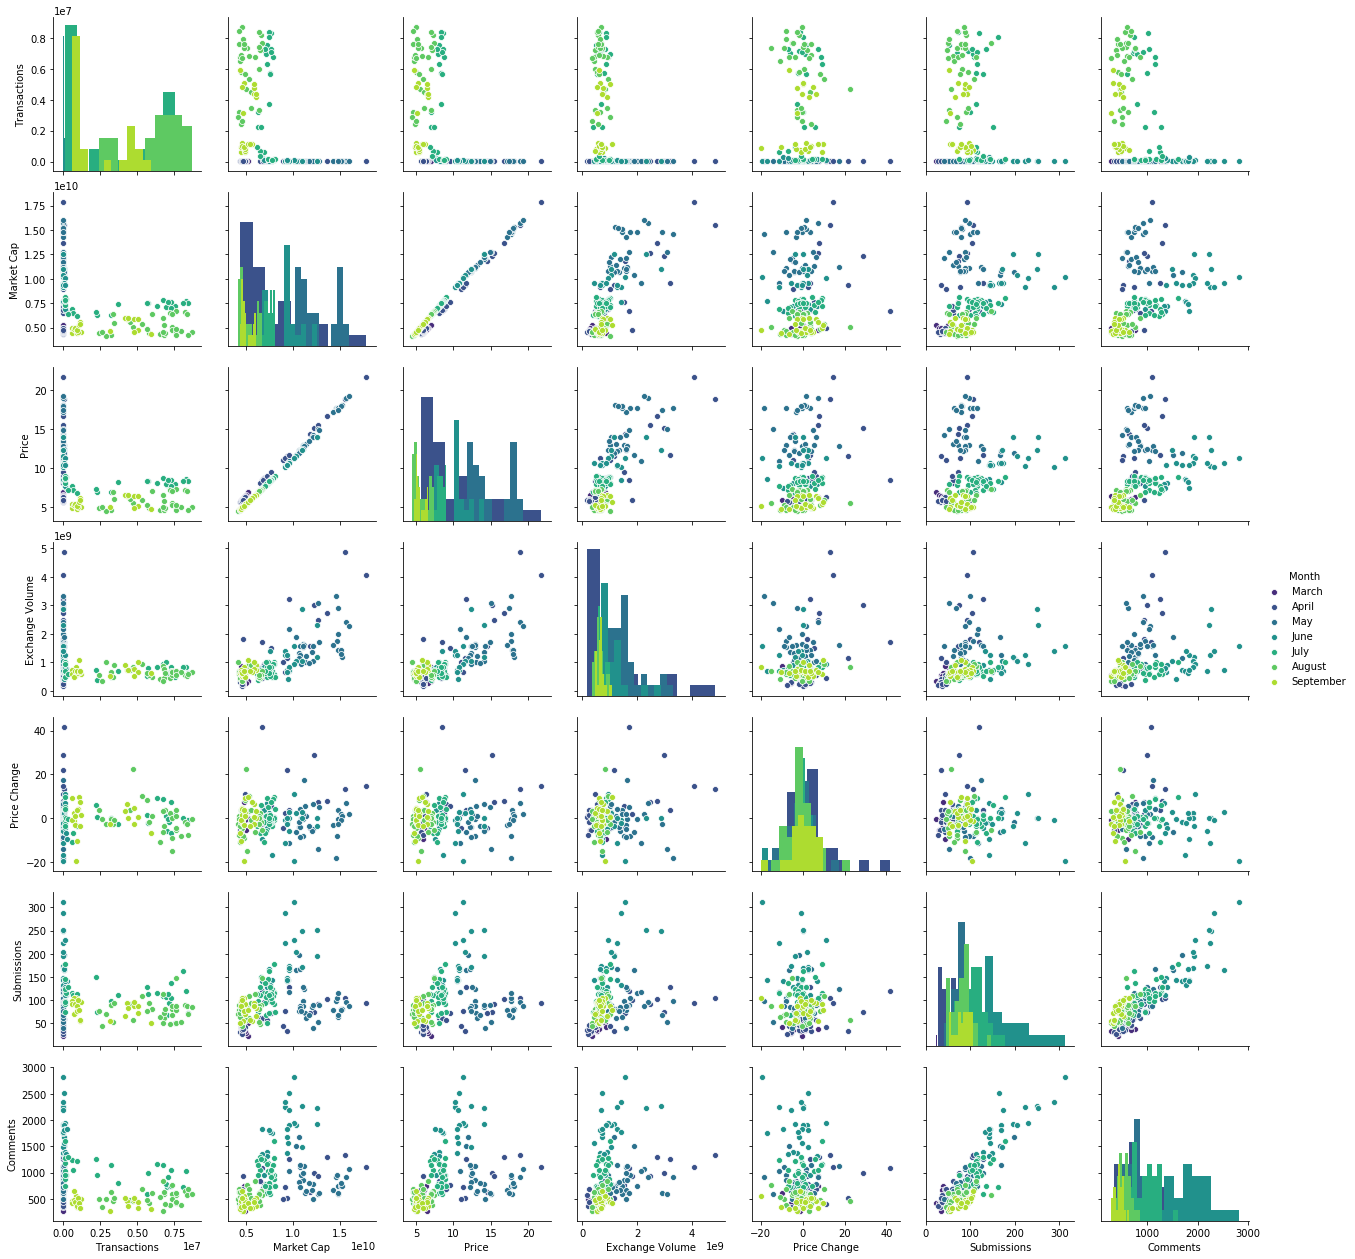

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,-0.407312,-0.445589,-0.312590,-0.054177,-0.121237,-0.323409
Market Cap,-0.407312,1.000000,0.993483,0.748510,0.073947,0.319962,0.413868
Price,-0.445589,0.993483,1.000000,0.760879,0.093018,0.252043,0.368665
Exchange Volume,-0.312590,0.748510,0.760879,1.000000,0.150630,0.259752,0.310405
Price Change,-0.054177,0.073947,0.093018,0.150630,1.000000,-0.067593,-0.066696
Submissions,-0.121237,0.319962,0.252043,0.259752,-0.067593,1.000000,0.861185
Comments,-0.323409,0.413868,0.368665,0.310405,-0.066696,0.861185,1.000000


In [6]:
#EOS
correlation('eos', 'eos')

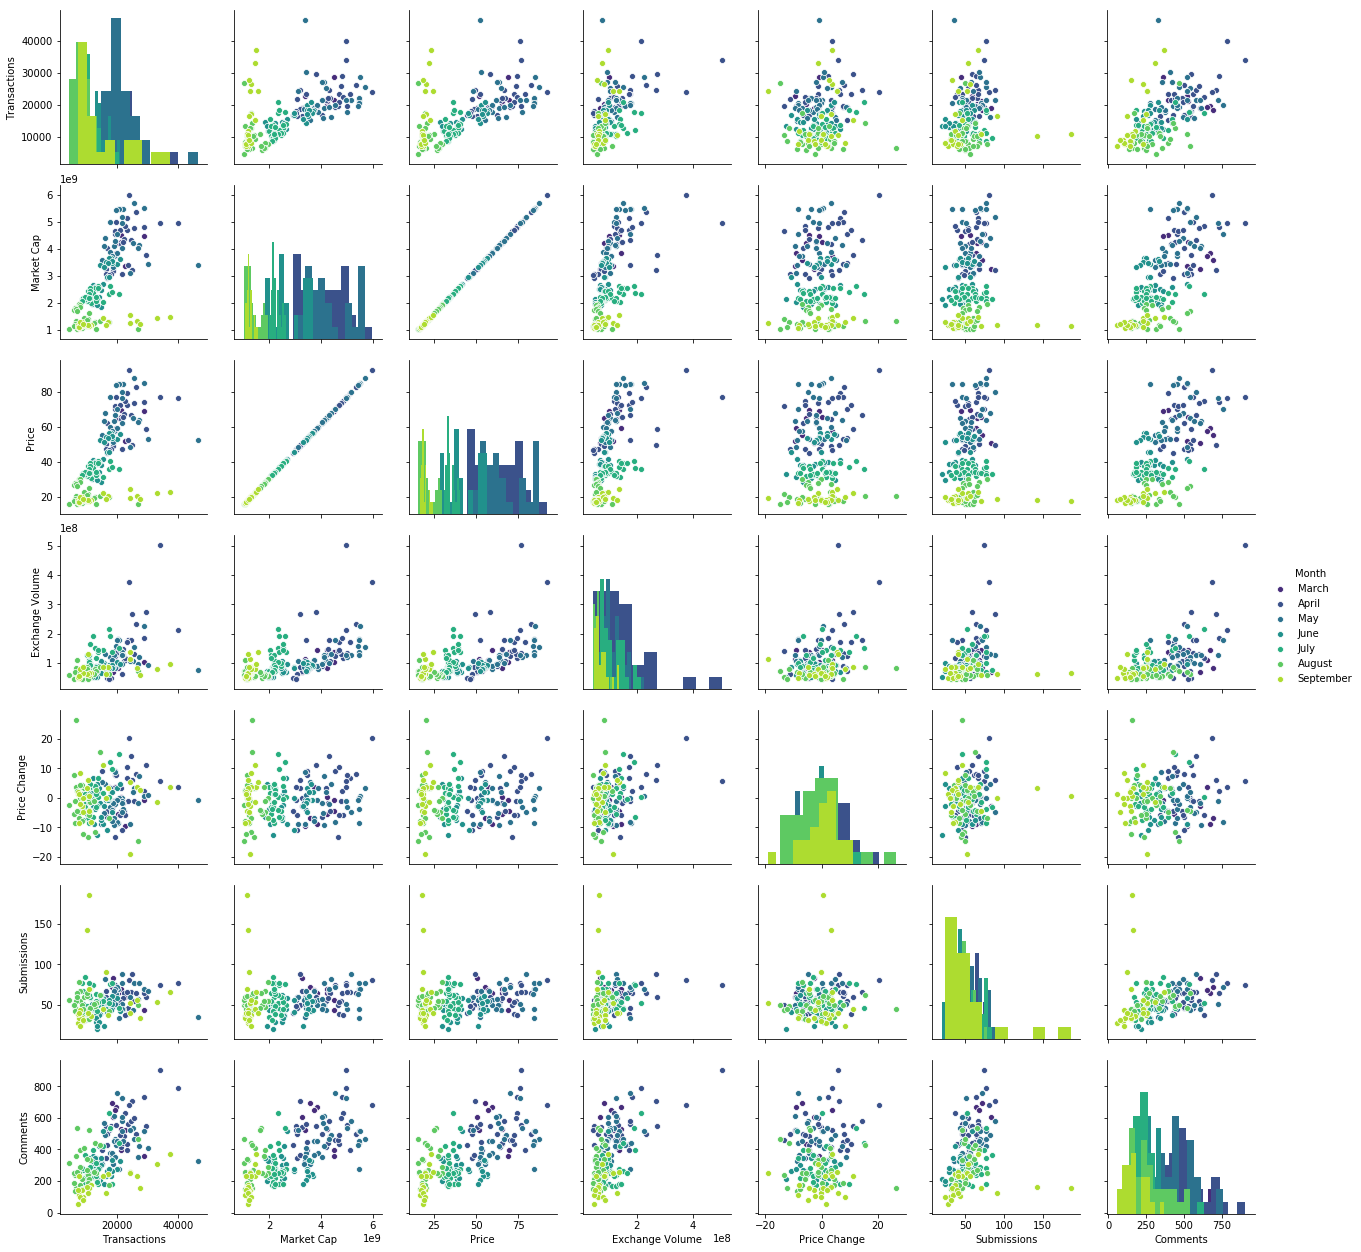

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.630406,0.630420,0.522773,0.103581,0.158484,0.590026
Market Cap,0.630406,1.000000,1.000000,0.579222,0.081340,0.197116,0.685965
Price,0.630420,1.000000,1.000000,0.579224,0.081349,0.197098,0.685963
Exchange Volume,0.522773,0.579222,0.579224,1.000000,0.291109,0.266134,0.578899
Price Change,0.103581,0.081340,0.081349,0.291109,1.000000,0.100034,0.024375
Submissions,0.158484,0.197116,0.197098,0.266134,0.100034,1.000000,0.313390
Comments,0.590026,0.685965,0.685963,0.578899,0.024375,0.313390,1.000000


In [7]:
#NEO
correlation('neo', 'neo')

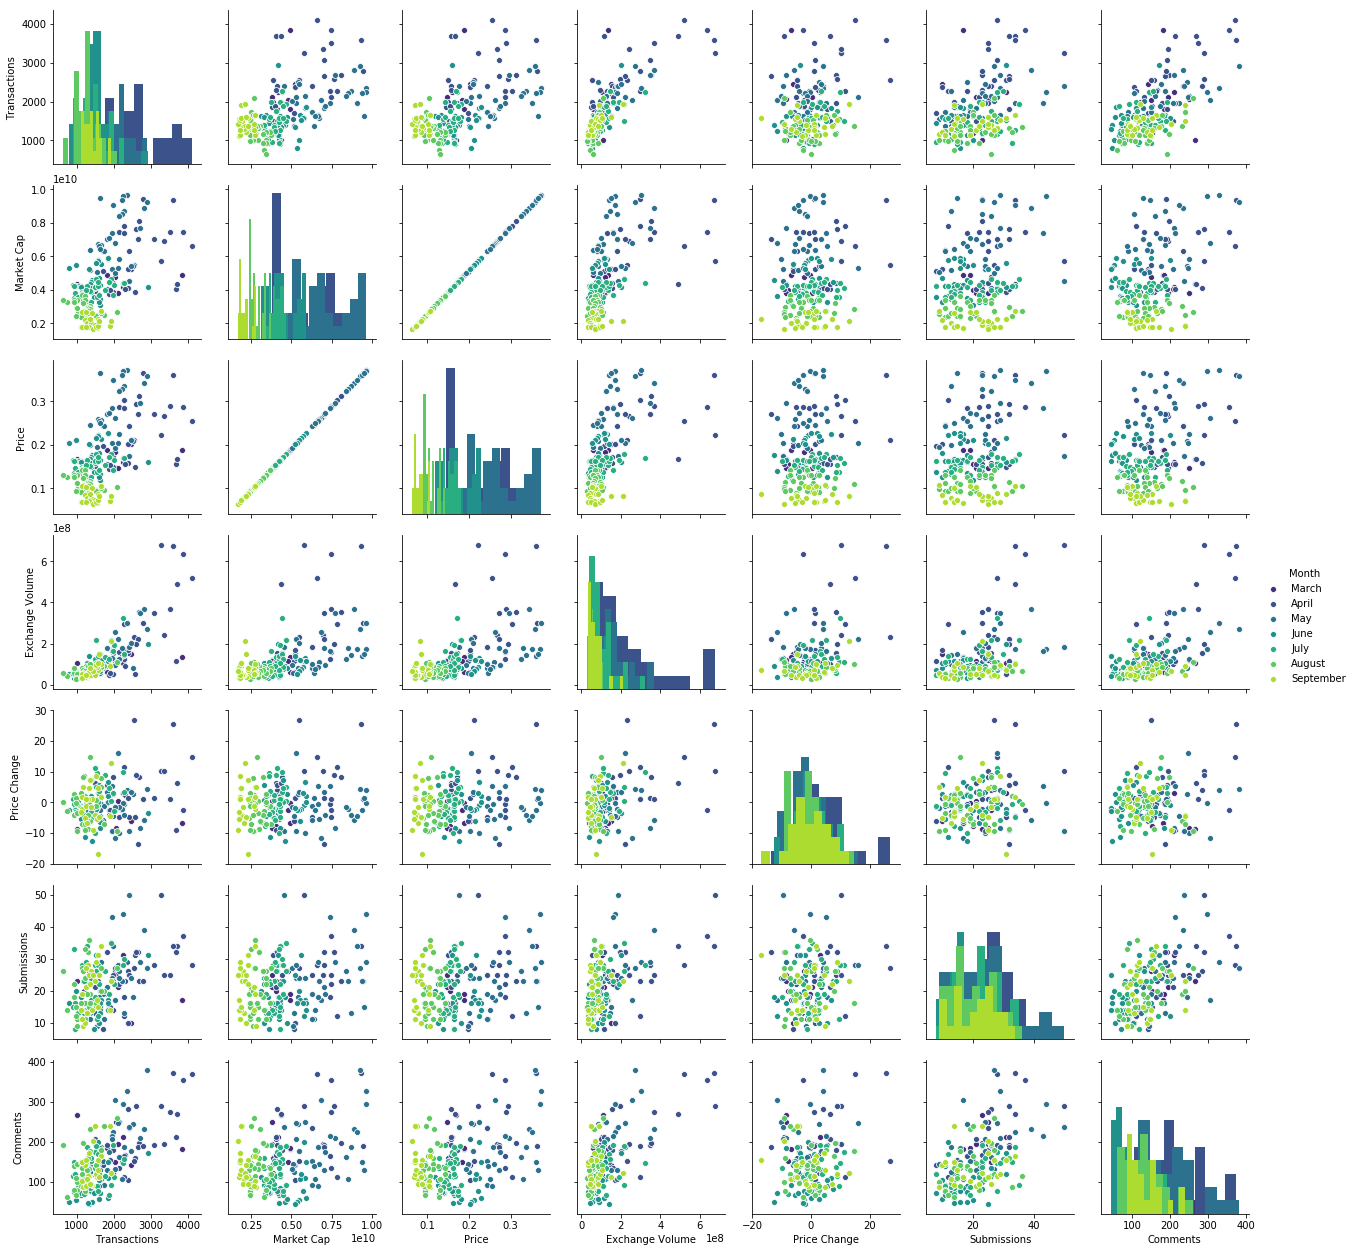

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.564156,0.564156,0.792892,0.215581,0.440048,0.649298
Market Cap,0.564156,1.000000,1.000000,0.567403,0.119895,0.244605,0.395778
Price,0.564156,1.000000,1.000000,0.567403,0.119895,0.244605,0.395778
Exchange Volume,0.792892,0.567403,0.567403,1.000000,0.350444,0.488553,0.633331
Price Change,0.215581,0.119895,0.119895,0.350444,1.000000,0.121133,0.132230
Submissions,0.440048,0.244605,0.244605,0.488553,0.121133,1.000000,0.521810
Comments,0.649298,0.395778,0.395778,0.633331,0.132230,0.521810,1.000000


In [8]:
#ADA
correlation('ada', 'cardano')

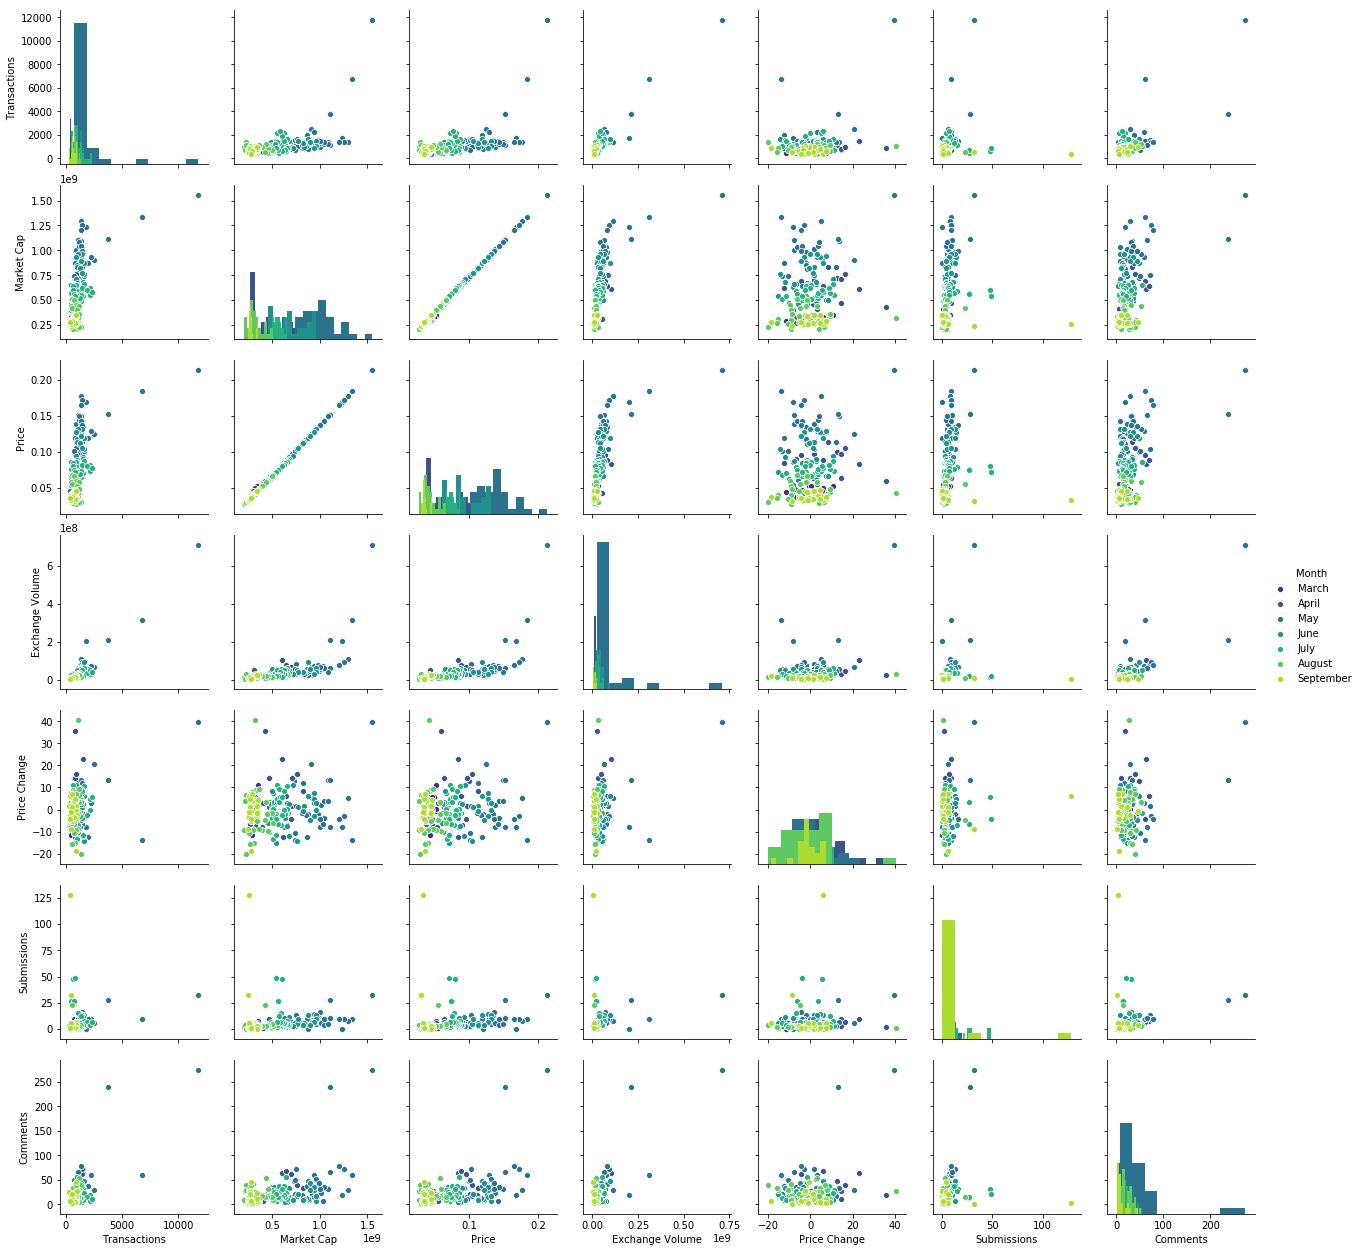

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.558692,0.556265,0.943412,0.267537,0.157257,0.731064
Market Cap,0.558692,1.000000,0.998698,0.606231,0.111155,0.127878,0.465833
Price,0.556265,0.998698,1.000000,0.609170,0.113673,0.123400,0.470869
Exchange Volume,0.943412,0.606231,0.609170,1.000000,0.296239,0.177467,0.776450
Price Change,0.267537,0.111155,0.113673,0.296239,1.000000,0.102107,0.303007
Submissions,0.157257,0.127878,0.123400,0.177467,0.102107,1.000000,0.195272
Comments,0.731064,0.465833,0.470869,0.776450,0.303007,0.195272,1.000000


In [9]:
#Zilliqa
correlation('zil', 'zilliqa')

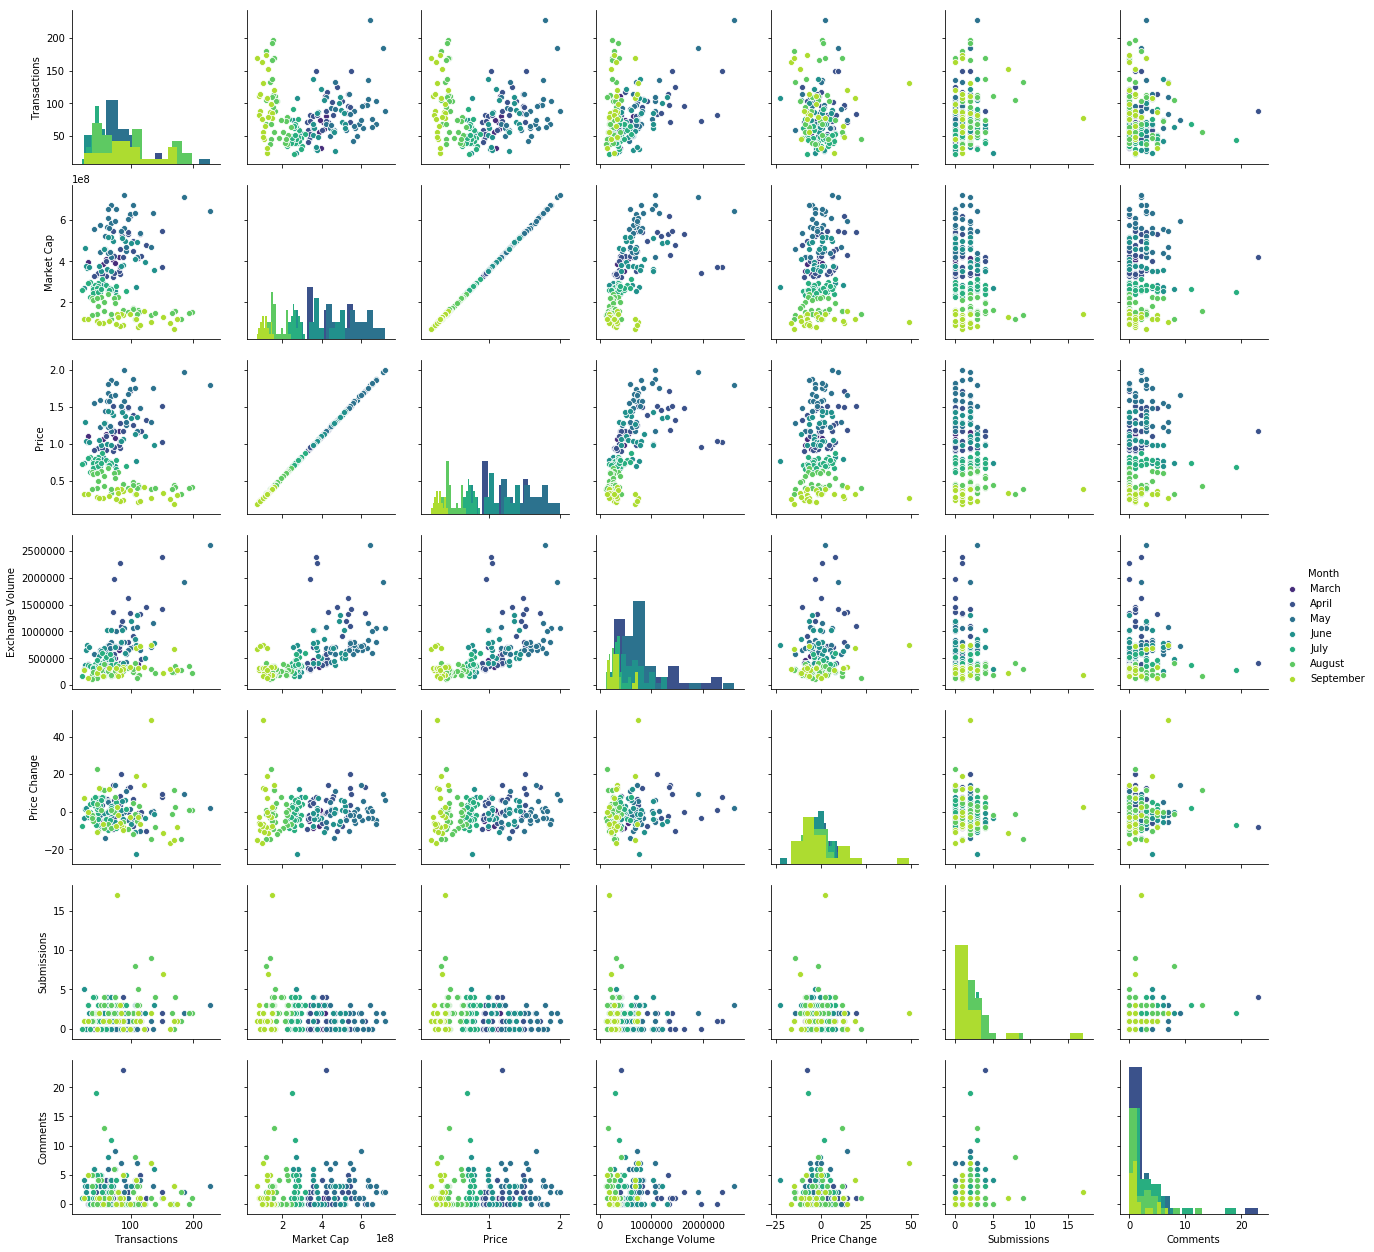

,Transactions,Market Cap,Price,Exchange Volume,Price Change,Submissions,Comments
Transactions,1.000000,0.007709,0.005192,0.349506,-0.027062,0.083592,-0.030002
Market Cap,0.007709,1.000000,0.999920,0.602016,0.095102,-0.255307,0.030019
Price,0.005192,0.999920,1.000000,0.600868,0.093581,-0.254728,0.031516
Exchange Volume,0.349506,0.602016,0.600868,1.000000,0.145105,-0.176275,-0.011331
Price Change,-0.027062,0.095102,0.093581,0.145105,1.000000,-0.085850,0.035543
Submissions,0.083592,-0.255307,-0.254728,-0.176275,-0.085850,1.000000,0.167129
Comments,-0.030002,0.030019,0.031516,-0.011331,0.035543,0.167129,1.000000


In [10]:
#RChain
correlation('rhoc', 'RChain')

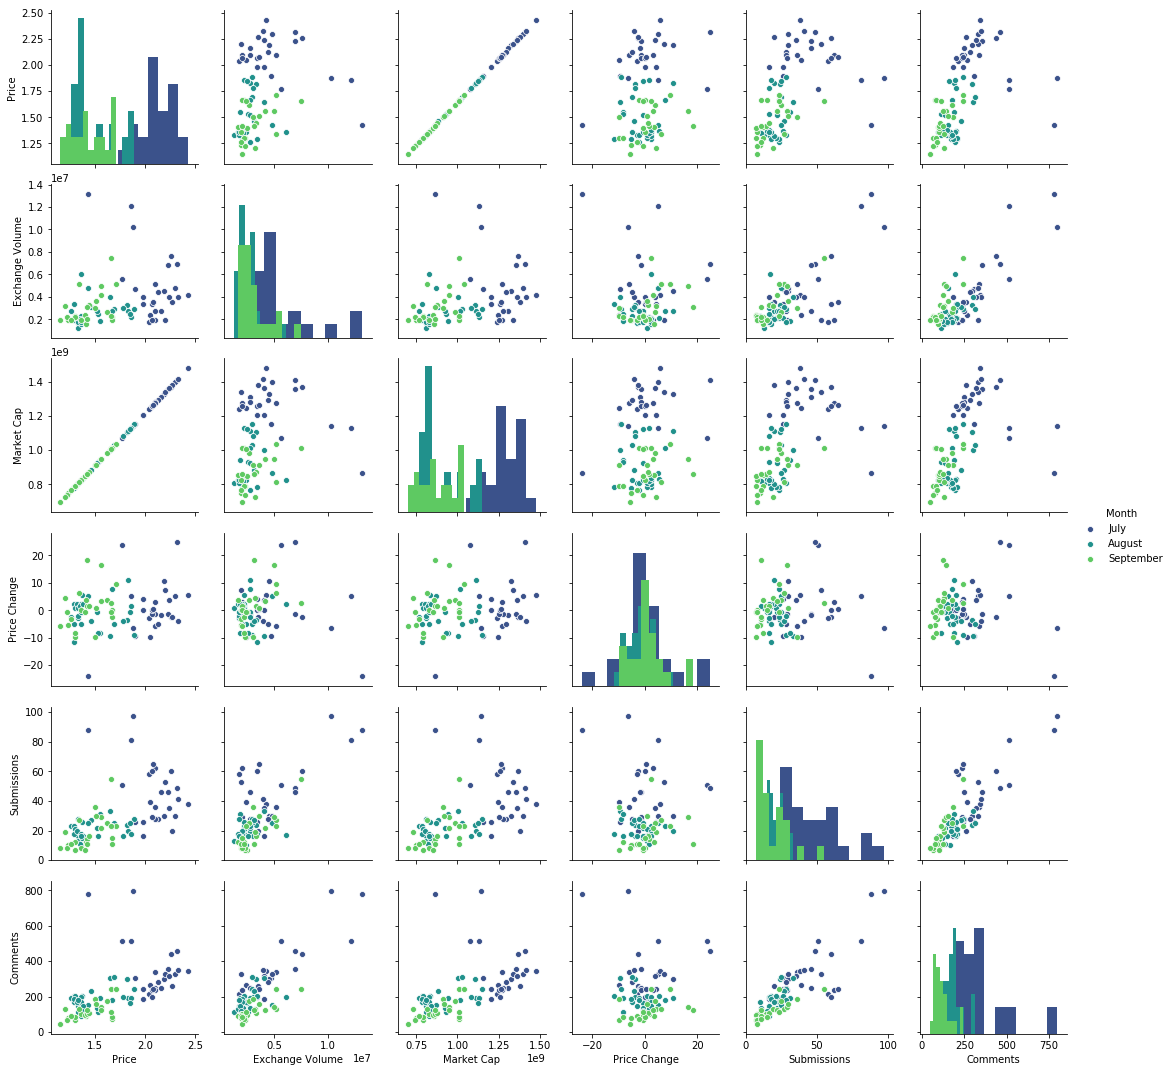

,Price,Exchange Volume,Market Cap,Price Change,Submissions,Comments
Price,1.000000,0.303197,0.999970,0.161016,0.534426,0.529011
Exchange Volume,0.303197,1.000000,0.302511,0.009701,0.715375,0.805182
Market Cap,0.999970,0.302511,1.000000,0.161048,0.533506,0.528172
Price Change,0.161016,0.009701,0.161048,1.000000,-0.024036,-0.045472
Submissions,0.534426,0.715375,0.533506,-0.024036,1.000000,0.833487
Comments,0.529011,0.805182,0.528172,-0.045472,0.833487,1.000000


In [11]:
#Tezos
correlation('tezos', 'tezos', 'coinmarketcap')